In [1]:
import sklearn

%tensorflow_version 2.x

# TensorFlow ≥2.0 is required
import tensorflow as tf
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

##Sequential api

keras.models.Sequential()



model.add()

##Function api

Connections are not linear, for example resnet has more complex connections.

Not all neural network models are simply sequential. Some may have complex topologies. Some may have multiple inputs and/or multiple outputs. For example, a Wide & Deep neural network (see [paper](https://ai.google/research/pubs/pub45413)) connects all or part of the inputs directly to the output layer.

### Data

In [2]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

## Wide and Deep

![alt text](https://i.ibb.co/JQHYv8g/Screenshot-from-2020-06-09-10-00-31.png)

### create wide and deep model with function api

In [3]:
X_train.shape[1:]

(8,)

In [4]:
from keras.layers import Input
from keras.layers import Dense
from keras.layers import concatenate

# create model
# Input shape 8 inputs
input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation='relu')(input_)
hidden2 = keras.layers.Dense(30, activation='relu')(hidden1)

concat = keras.layers.concatenate([input_,hidden2])

output = keras.layers.Dense(1)(concat)

model = keras.models.Model(inputs = [input_], outputs = [output])

In [5]:
# model summary, plot
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 30)           270         input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 30)           930         dense[0][0]                      
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 38)           0           input_1[0][0]                    
                                                                 dense_1[0][0]                

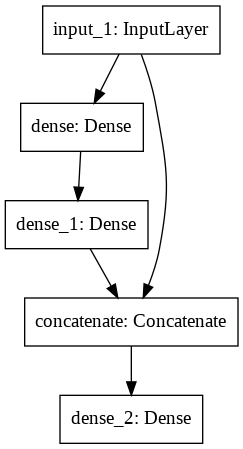

In [7]:
keras.utils.plot_model(model)

### compile and fit model

In [8]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)

Epoch 1/10
363/363 [==============================] - 1s 2ms/step - loss: 3.0548 - val_loss: 2.5067
Epoch 2/10
363/363 [==============================] - 0s 1ms/step - loss: 0.6783 - val_loss: 1.7788
Epoch 3/10
363/363 [==============================] - 0s 1ms/step - loss: 0.6178 - val_loss: 0.5661
Epoch 4/10
363/363 [==============================] - 0s 1ms/step - loss: 0.5833 - val_loss: 0.6407
Epoch 5/10
363/363 [==============================] - 0s 1ms/step - loss: 0.5515 - val_loss: 0.5005
Epoch 6/10
363/363 [==============================] - 0s 1ms/step - loss: 0.5360 - val_loss: 0.4873
Epoch 7/10
363/363 [==============================] - 0s 1ms/step - loss: 0.4972 - val_loss: 0.4730
Epoch 8/10
363/363 [==============================] - 0s 1ms/step - loss: 0.4903 - val_loss: 0.4732
Epoch 9/10
363/363 [==============================] - 0s 1ms/step - loss: 0.4743 - val_loss: 0.4824
Epoch 10/10
162/162 [==============================] - 0s 820us/step - loss: 0.4536


## A more complex model 

![alt text](https://i.ibb.co/gRs164Q/Screenshot-from-2020-06-09-10-17-32.png)

### create model

In [14]:
# model
# inputs
input1 = keras.layers.Input(shape = [5], name = 'wide')
input2 = keras.layers.Input(shape = [6], name = 'deep')

# hidden
hidden1 = keras.layers.Dense(30, activation='relu')(input2)
hidden2 = keras.layers.Dense(30, activation='relu')(hidden1)
concat = keras.layers.concatenate([input1, hidden2])

#outputs
output = keras.layers.Dense(1)(concat)
aux_output = keras.layers.Dense(1)(hidden2)

model1 = keras.models.Model(inputs = [input1, input2], outputs = [output, aux_output])

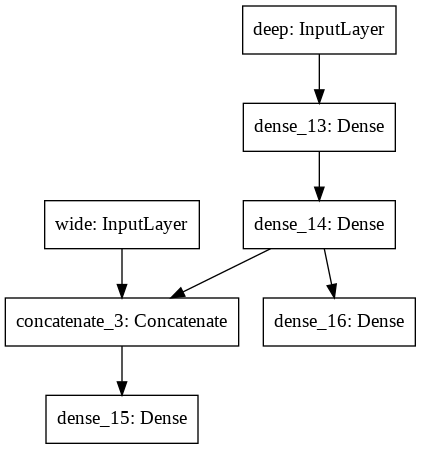

In [15]:
# plot_model
keras.utils.plot_model(model1)

## Subclass API

Another model in keras is Subclass API.
Sequential: no connectivity access

Function: Can access connections

Subclass: For researches and tests and use conditions and loops

In [18]:
# create model
class WideAndDeepModel(keras.models.Model):
  # Define layers but not inputs
  def __init__(self, units=30, activation='relu', **kwargs):
    super().__init__(**kwargs)
    self.hidden1 = keras.layers.Dense(units, activation='relu')
    self.hidden2 = keras.layers.Dense(units, activation='relu')

    self.main_output = keras.layers.Dense(1)
    self.aux_output = keras.layers.Dense(1)

  # Model.fit
  # Define connections
  def call(self, inputs):
    input1, input2 = inputs
    hidden1 = self.hidden1(input2)
    hidden2 = self.hidden2(hidden1)
    concat = keras.layers.concatenate([input1, hidden2])
    main_output = self.main_output(concat)
    aux_output = self.aux_output(hidden2)

    return main_output, aux_output



model = WideAndDeepModel()


### prepare data

In [19]:
X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]


### compile and load data

In [20]:
model.compile(loss="mse", loss_weights=[0.9, 0.1], optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit((X_train_A, X_train_B), (y_train, y_train), epochs=10,
                    validation_data=((X_valid_A, X_valid_B), (y_valid, y_valid)))


Epoch 1/10
363/363 [==============================] - 1s 2ms/step - loss: 4.1975 - output_1_loss: 4.0921 - output_2_loss: 5.1457 - val_loss: 2.5348 - val_output_1_loss: 0.9570 - val_output_2_loss: 16.7353
Epoch 2/10
363/363 [==============================] - 1s 2ms/step - loss: 1.1691 - output_1_loss: 0.8810 - output_2_loss: 3.7620 - val_loss: 2.6386 - val_output_1_loss: 0.7731 - val_output_2_loss: 19.4285
Epoch 3/10
363/363 [==============================] - 1s 2ms/step - loss: 0.8593 - output_1_loss: 0.6666 - output_2_loss: 2.5932 - val_loss: 2.5123 - val_output_1_loss: 0.6065 - val_output_2_loss: 19.6646
Epoch 4/10
363/363 [==============================] - 1s 1ms/step - loss: 0.7755 - output_1_loss: 0.6161 - output_2_loss: 2.2095 - val_loss: 2.4134 - val_output_1_loss: 0.7797 - val_output_2_loss: 17.1163
Epoch 5/10
363/363 [==============================] - 1s 2ms/step - loss: 0.7002 - output_1_loss: 0.5739 - output_2_loss: 1.8375 - val_loss: 2.0326 - val_output_1_loss: 0.6678 - va

In [21]:
total_loss, main_loss, aux_loss = model.evaluate((X_test_A, X_test_B), (y_test, y_test))
print(total_loss)
print(main_loss)
print(aux_loss)


162/162 [==============================] - 0s 938us/step - loss: 0.5501 - output_1_loss: 0.4733 - output_2_loss: 1.2410
0.5501102209091187
0.4733429551124573
1.2410166263580322


## Custom Layer

![alt text](https://i.ibb.co/rcRpCWn/Screenshot-from-2020-06-09-11-41-31.png)

In [23]:
## create layer
class ResidualBlock(keras.layers.Layer):
  def __init__(self, n_layers, n_neurons, **kwargs):
    super().__init__(**kwargs)
    # Hidden is an array of custom size
    self.hidden = [keras.layers.Dense(n_neurons, activation='relu') for _ in range(n_layers)]


  def call(self, inputs):
    z = inputs
    for layers in self.hidden:
      z = layer(z)
    return inputs + z

![alt text](https://i.ibb.co/y4dGdjj/Screenshot-from-2020-06-09-11-25-31.png)

In [28]:
# create final model
class ResidualRegressor(keras.models.Model):
  def __init__(self, output_dim, **kwargs):
    super().__init__(**kwargs)
    self.hidden = keras.layers.Dense(30, activation='relu')
    self.block1 = ResidualBlock(2, 30)
    self.block2 = ResidualBlock(2, 30)
    self.out = keras.layers.Dense(output_dim)

  def call(self, inputs):
    z = self.hidden(inputs)
    for _ in range(3):
      z = self.block1(z)

    z = self.block2(z)

    return self.out(z)


In [29]:
model = ResidualRegressor(2)